In [1]:
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview
import pickle
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
from astropy import units as u, constants  as c

pc = c.pc.cgs.value
kB  = c.k_B.cgs.value
Msun = c.M_sun.cgs.value
G = c.G.cgs.value
Myr = u.Myr.in_units("s")
mp = c.m_p.cgs.value

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble" : r'\boldmath'
})

/Users/girichidis/Software/YT-2022-07-22/yt-conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# definitions

Nside=64
Npix = hp.nside2npix(Nside)
cd  = "c000167" # fiducial coldens

def _read_fields(pickle_path, fields=None):
    """
    Function to read total a pickle file.
    if show is true, only show the content of the pickle
    """
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    if fields is None:
        print(data.keys())
        return
    else:
        ret_data = {}
        for f in fields:
            ret_data[f] = data[f]
        return data["simtime_Myr"], ret_data


In [3]:
fields = ['Tmw', 'Tlw', 'Tew']
labels = ['$\langle T\\rangle,~\mathrm{mass~weighted}$', 
          '$\langle T\\rangle,~\mathrm{lumi~weighted}$', 
          '$\langle T\\rangle,~\mathrm{EM~weighted}$']
colors = ["C0", "C1", "C2"]

all_dat = {}

for file_no in range(800, 1302, 2):
    pickle_path = "datafiles/data-01-20keV/SILCC_hdf5_plt_cnt_" + str(file_no).zfill(4) + "-r0150-" + cd + "-data.pkl"
    t, data = _read_fields(pickle_path, fields=fields)
    
    all_dat[file_no] = {}
    all_dat[file_no]["time"] = t
    for f in fields:
        all_dat[file_no][f] = data[f]

In [4]:
# compute median etc

pdat = {}
for f in fields:
    pdat[f] = {}
    pdat[f]["all_times"] = []
    pdat[f]["all_median"] = []
    pdat[f]["all_perclo"] = []
    pdat[f]["all_perchi"] = []
    for it in all_dat.keys():
        pdat[f]["all_times"].append(all_dat[it]["time"])
        pdat[f]["all_median"].append(np.median(all_dat[it][f]))
        pdat[f]["all_perclo"].append(np.percentile(all_dat[it][f], 20))
        pdat[f]["all_perchi"].append(np.percentile(all_dat[it][f], 80))

In [5]:
# load SN data
ctr = [-80*pc, -150*pc, 0*pc]

dat = np.loadtxt("datafiles/time-evol-emission-volume-R100.txt")

# also load SN data file
SNe = np.loadtxt("datafiles/SNoutput.dat")

# select all SNe that occur within a radius of 100 pc around ctr
SN_rad = np.sqrt((SNe[:,1]-ctr[0])**2 + (SNe[:,2]-ctr[1])**2 + (SNe[:,3]-ctr[2])**2)/pc
idx = np.where(SN_rad < 100)
idx2 = np.where((SN_rad >=100) & (SN_rad < 120))

Text(0, 0.5, '$T~(\\mathrm{K})$')

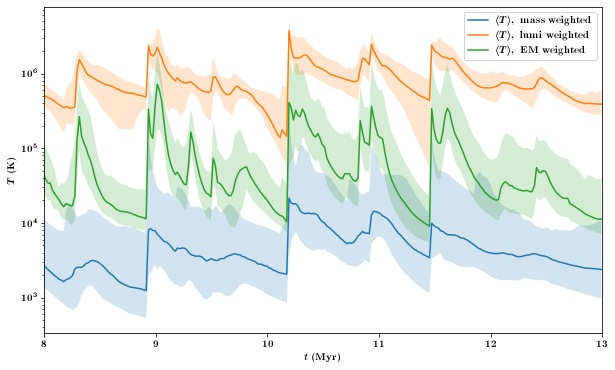

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
for f, l in zip(fields, labels):
    ax.fill_between(pdat[f]["all_times"], y1=pdat[f]["all_perclo"], y2=pdat[f]["all_perchi"], alpha=0.2)
    ax.plot(pdat[f]["all_times"], pdat[f]["all_median"], label=l)
ax.set_yscale("log")
ax.set_xlim(8,13)
ax.legend()
ax.set_xlabel("$t~(\\mathrm{Myr})$")
ax.set_ylabel("$T~(\\mathrm{K})$")

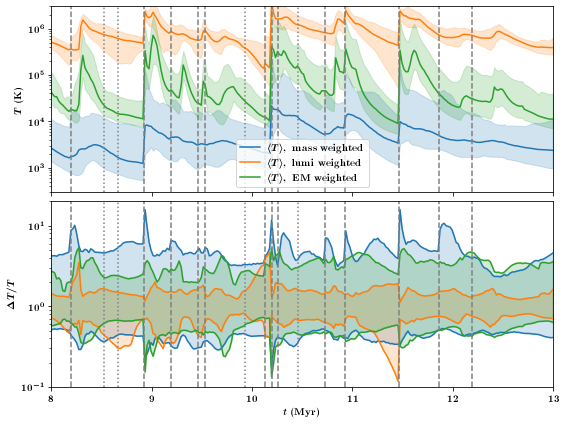

In [7]:

fig, ax = plt.subplots(figsize=(9,7), nrows=2, sharex=True)
for f, c, l in zip(fields, colors, labels):
    ax[0].fill_between(pdat[f]["all_times"],
                       y1=pdat[f]["all_perclo"],
                       y2=pdat[f]["all_perchi"], color=c, alpha=0.2)
    ax[0].plot(pdat[f]["all_times"], pdat[f]["all_median"], label=l)
ax[0].set_yscale("log")
ax[0].set_xlim(8,13)
ax[0].legend()
ax[0].set_ylabel("$T~(\\mathrm{K})$")

for f, c, l in zip(fields, colors, labels):
    ax[1].fill_between(pdat[f]["all_times"],
                       y1=np.array(pdat[f]["all_perclo"])/np.array(pdat[f]["all_median"]), \
                       y2=np.array(pdat[f]["all_perchi"])/np.array(pdat[f]["all_median"]), \
                       alpha=0.2, color=c)
    ax[1].plot(pdat[f]["all_times"], np.array(pdat[f]["all_perclo"])/np.array(pdat[f]["all_median"]),
               label=f, color=c)
    ax[1].plot(pdat[f]["all_times"], np.array(pdat[f]["all_perchi"])/np.array(pdat[f]["all_median"]), 
               label=f, color=c)
ax[1].set_xlabel("$t~(\\mathrm{Myr})$")
ax[1].set_ylabel("$\Delta T / T$")
ax[1].set_yscale("log")

ax0y0 = 3e2
ax0y1 = 3e6
ax1y0 = 0.1
ax1y1 = 20
ax[0].set_ylim(ax0y0, ax0y1)
ax[1].set_ylim(ax1y0, ax1y1)

# add SNe
ax[0].vlines(SNe[idx,0]/Myr, ax0y0,ax0y1, color="grey", ls="--")
ax[1].vlines(SNe[idx,0]/Myr, ax1y0,ax1y1, color="grey", ls="--")
ax[0].vlines(SNe[idx2,0]/Myr, ax0y0,ax0y1, color="grey", ls=":")
ax[1].vlines(SNe[idx2,0]/Myr, ax1y0,ax1y1, color="grey", ls=":")

fig.subplots_adjust(hspace=0.05)
fig.savefig("plots/temperature-anisotropy.pdf", bbox_inches="tight")